In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from utils.dataloader import get_train_test_loaders
from utils.model import CustomVGG
from utils.helper import train, evaluate, predict_localize

## Parameters

In [3]:
data_folder = "data/leather"
input_size = (224, 224)
neg_class = 0

batch_size = 10
lr = 0.0001
epochs = 2  # 7
class_weight = [5, 1] if neg_class == 0 else [1, 5]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

localization_thres = 10
n_cv_folds = 5

# Data

In [4]:
train_loader, test_loader = get_train_test_loaders(
    root=data_folder,
    batch_size=batch_size,
    test_size=0.2,
    random_state=42,
)

Dataset data/leather: N Images = 369, Share of anomalies = 0.249


In [5]:
for batch in train_loader:
    break

In [6]:
batch[1]

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

# Model Training

In [10]:
model = CustomVGG()

# class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weight)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
epochs = 2

In [12]:
model = train(train_loader, model, optimizer, criterion, epochs, device)

Epoch 1/2: Loss = 0.4708, Accuracy = 0.7931
Epoch 2/2: Loss = 0.2130, Accuracy = 0.9172


In [ ]:
model_path = "model.h5"
torch.save(model, model_path)
# model = torch.load(model_path, map_location=device)

# Evaluation

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Accuracy: 0.8784
Balanced Accuracy: 0.7500



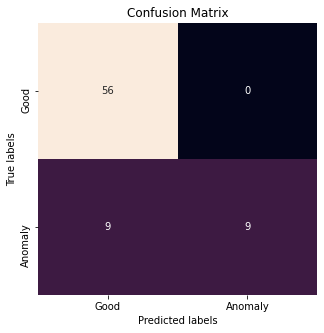

In [14]:
evaluate(model, test_loader, device)

# Cross Validation

In [ ]:
cv_folds = get_cv_train_test_loaders(
    root=data_folder,
    batch_size=batch_size,
    img_size=input_size,
    n_folds=n_cv_folds,
)

class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weight)

for i, (train_loader, test_loader) in enumerate(cv_folds):
    print(f"Fold {i+1}/{n_cv_folds}")
    model = CustomVGG(input_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model = train(train_loader, model, optimizer, criterion, epochs, device)
    evaluate(model, test_loader, device)

# Visualization

In [24]:
localization_thres

10

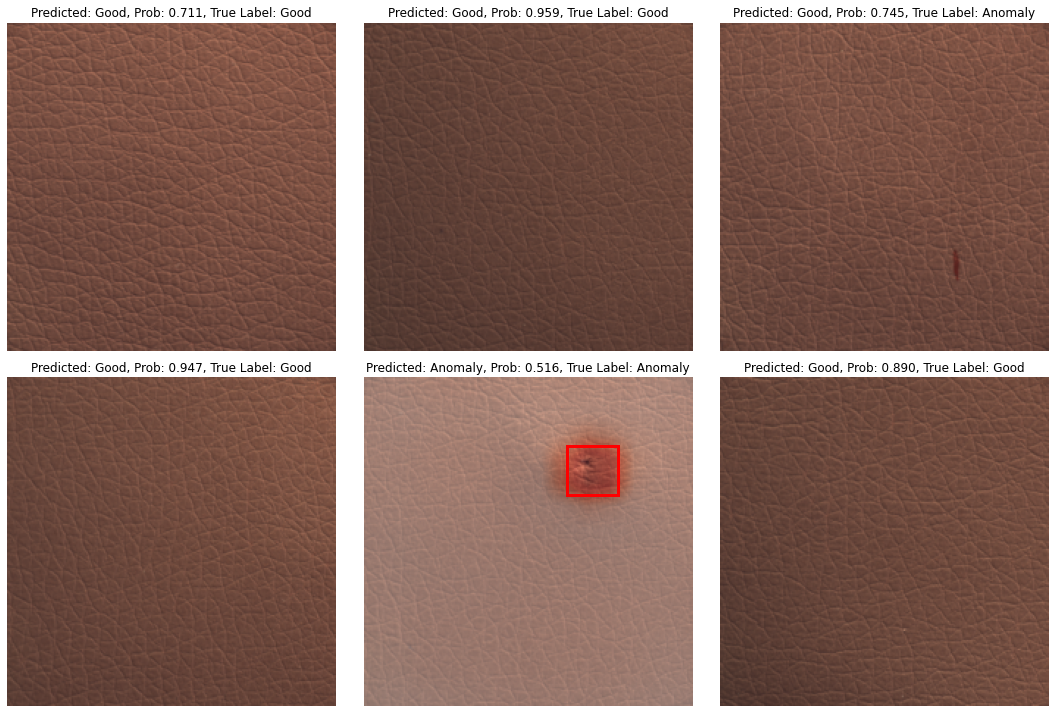

In [28]:
predict_localize(
    model,
    test_loader,
    device,
    thres=5,
    neg_class=1,
    n_samples=6,
)